In [ ]:
# !pip install keras

In [ ]:
# !pip install tensorflow==1.13.2
# !pip install -U "segmentation-models"
# !pip install -U "tensorflow==2.1"
# !pip install -U "Keras==2.3.1"
# !pip install -U "tensorflow-estimator==2.1"

In [ ]:
# !pip install opencv-python

In [ ]:
# !pip install -U "Keras==2.3.1"

In [1]:
import tensorflow as tf
import keras #must be 2.3.1
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
from PIL import Image

Using TensorFlow backend.


In [14]:
import pandas as pd
import os 
# import csv and rename it
retina_df = pd.read_csv('trainLabels.csv', index_col = False).rename(columns = {'image':'Image', 'level':'Level'})

# Get PatientId & Eye by looking at image number
retina_df['PatientId'] = retina_df['Image'].map(lambda x: x.split('_',1)[0])
retina_df['LeftEye'] = retina_df['Image'].map(lambda x: 1 if x.split('_',1)[1] == 'left' else 0)

# Get path to each file
cwd = os.getcwd()
base_image_dir = os.path.join('.', 'Image/train')
retina_df['Path'] = retina_df['Image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))

In [15]:
retina_df['Exist'] = retina_df['Path'].map(os.path.exists)
retina_df = retina_df[retina_df['Exist']==True]
retina_df.sample(3)

,Image,Level,PatientId,LeftEye,Path,Exist
13522,16978_left,0,16978,1,./Image/train/16978_left.jpeg,True
4224,5303_left,0,5303,1,./Image/train/5303_left.jpeg,True
29841,37736_right,0,37736,0,./Image/train/37736_right.jpeg,True


array([[<AxesSubplot:title={'center':'Level'}>,
        <AxesSubplot:title={'center':'LeftEye'}>]], dtype=object)

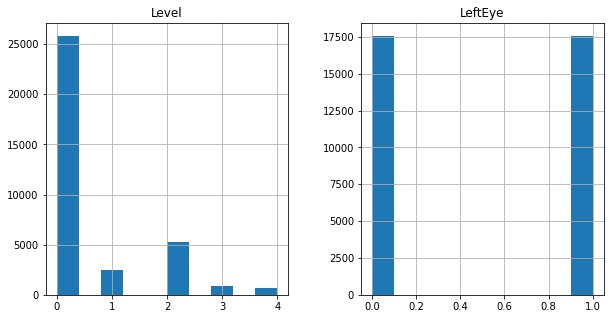

In [16]:
# EDA
retina_df[['Level', 'LeftEye']].hist(figsize = (10, 5))


In [17]:
retina_df.groupby(['Level', 'LeftEye']).size().reset_index(name='count')

,Level,LeftEye,count
0,0,0,12939
1,0,1,12871
2,1,0,1231
3,1,1,1212
4,2,0,2590
5,2,1,2702
6,3,0,448
7,3,1,425
8,4,0,355
9,4,1,353


In [18]:
# Split dataset to training or test dataset (to use stratify approach since dataset unbalanced)
from sklearn.model_selection import train_test_split
retina_id = retina_df[['PatientId', 'Level']].drop_duplicates()

train_id , test_id = train_test_split(retina_id['PatientId'], test_size = 1/3, random_state =23, stratify = retina_id['Level'])
train_data = retina_df[retina_df['PatientId'].isin(train_id)]
test_data = retina_df[retina_df['PatientId'].isin(test_id)]
print(f"No. of training sample: {train_data.shape[0]}")
print(f"No. of test sample: {test_data.shape[0]}")


No. of training sample: 24384
No. of test sample: 12686


In [19]:
train_df = train_data.groupby(['Level', 'LeftEye']).apply(lambda x: x.sample(200, replace = True)
                                                      ).reset_index(drop = True)


In [20]:
train_df.shape

(2000, 6)

In [21]:
import numpy as np

In [22]:
x_train = []
for path in train_df['Path']:
    img_arr = cv2.imread(path)
    img_arr = cv2.resize(img_arr,(224,224))
    img_arr = img_arr/255 #normalize
    x_train.append(img_arr)
X = np.array(x_train)

np.save('x_train_arr', X)

In [12]:
X = np.load('x_train_arr.npy')

In [23]:
## Perform Encoding
from keras.utils.np_utils import to_categorical
# retina_df['LevelCat'] = retina_df['Level'].map(lambda x: to_categorical(x, 1+retina_df['Level'].max()))
y = to_categorical(train_df['Level'], dtype ="uint8")

In [24]:
## Split the training set into 2 (train and test for evaluation purpose)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.4)

In [25]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

In [26]:
import tensorflow
model = tensorflow.keras.Sequential()

In [27]:
from tensorflow.keras.layers import LeakyReLU, Activation, Dropout, Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization

In [28]:
# model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(224,224,3) ,padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(5, activation='softmax'))

In [29]:
# compile the model <- use "categorical_crossentropy" since it's categorical.
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [30]:
result = model.fit(X_train, y_train, batch_size = 32,  epochs=20, validation_data=(X_test, y_test))

Train on 1200 samples, validate on 800 samples
Epoch 1/20
1200/1200 [==============================] - 239s 199ms/sample - loss: 1.7195 - accuracy: 0.1900 - val_loss: 1.6076 - val_accuracy: 0.2275
Epoch 2/20
1200/1200 [==============================] - 241s 201ms/sample - loss: 1.6006 - accuracy: 0.2333 - val_loss: 1.6055 - val_accuracy: 0.2400
Epoch 3/20
1200/1200 [==============================] - 238s 198ms/sample - loss: 1.5894 - accuracy: 0.2675 - val_loss: 1.6161 - val_accuracy: 0.2212
Epoch 4/20
1200/1200 [==============================] - 238s 198ms/sample - loss: 1.5792 - accuracy: 0.2625 - val_loss: 1.6229 - val_accuracy: 0.2338
Epoch 5/20
1200/1200 [==============================] - 339s 283ms/sample - loss: 1.5477 - accuracy: 0.2917 - val_loss: 1.5888 - val_accuracy: 0.2475
Epoch 6/20
1200/1200 [==============================] - 239s 199ms/sample - loss: 1.5266 - accuracy: 0.3092 - val_loss: 1.6133 - val_accuracy: 0.2412
Epoch 7/20
1200/1200 [==============================]

In [31]:
# if save_model:
#     model.save_weights("retina.ckpt")

model.save('model2.h5')
model.save('model2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model3/assets


In [32]:
x = tf.saved_model.load('model2.h5')

In [33]:
#model summary

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       7

In [34]:
import matplotlib.pyplot as plt

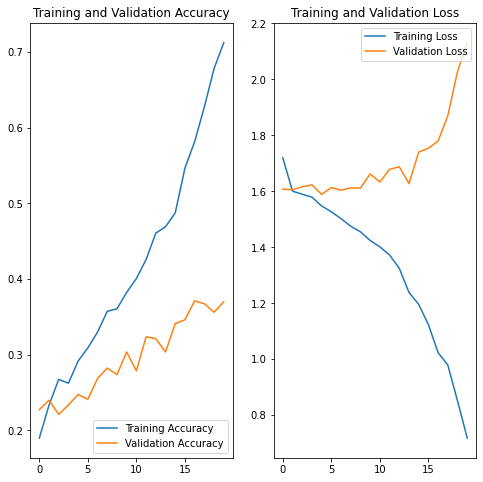

In [35]:
# Visualize training results

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



Loss function for validation dataset is much higher than Training.

use dropout

In [36]:
model2 = tensorflow.keras.Sequential()
model2.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(224,224,3) ,padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D((2, 2),padding='same'))
model2.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model2.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model2.add(Flatten())
model2.add(Dense(128, activation='linear'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Dropout(0.50))
model2.add(Dense(5, activation='softmax'))

# compile the model <- use "categorical_crossentropy" since it's categorical.
model2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])


In [37]:
result2 = model2.fit(X_train, y_train, batch_size = 32,  epochs=20, validation_data=(X_test, y_test))

Train on 1200 samples, validate on 800 samples
Epoch 1/20
1200/1200 [==============================] - 247s 206ms/sample - loss: 1.6743 - accuracy: 0.2083 - val_loss: 1.6083 - val_accuracy: 0.1787
Epoch 2/20
1200/1200 [==============================] - 246s 205ms/sample - loss: 1.6041 - accuracy: 0.2375 - val_loss: 1.6020 - val_accuracy: 0.2350
Epoch 3/20
1200/1200 [==============================] - 248s 207ms/sample - loss: 1.5957 - accuracy: 0.2608 - val_loss: 1.6493 - val_accuracy: 0.1937
Epoch 4/20
1200/1200 [==============================] - 248s 206ms/sample - loss: 1.5793 - accuracy: 0.2842 - val_loss: 1.6977 - val_accuracy: 0.2300
Epoch 5/20
1200/1200 [==============================] - 248s 206ms/sample - loss: 1.5801 - accuracy: 0.2717 - val_loss: 1.6414 - val_accuracy: 0.2237
Epoch 6/20
1200/1200 [==============================] - 248s 206ms/sample - loss: 1.5789 - accuracy: 0.2867 - val_loss: 1.6058 - val_accuracy: 0.2412
Epoch 7/20
1200/1200 [==============================]

In [38]:
# if save_model:
#     model.save_weights("retina.ckpt")

model2.save('model2.h5')
model2.save('model2')

INFO:tensorflow:Assets written to: model4/assets


In [39]:
#model summary

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 56, 56, 128)      

In [40]:
import matplotlib.pyplot as plt

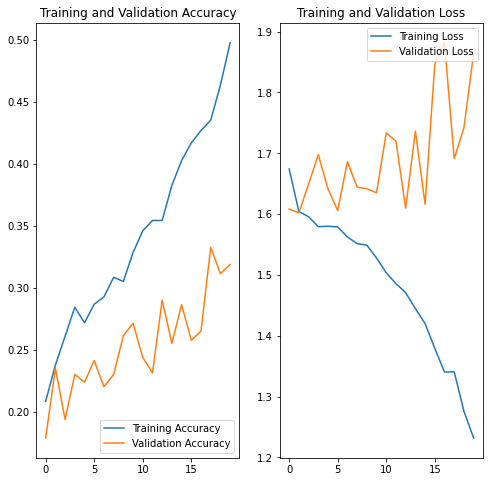

In [41]:
# Visualize training results

acc = result2.history['accuracy']
val_acc = result2.history['val_accuracy']

loss = result2.history['loss']
val_loss = result2.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [27]:
test_df = test_data.groupby(['Level', 'LeftEye']).apply(lambda x: x.sample(50, replace = True)
                                                      ).reset_index(drop = True)
